In [1]:
import pandas as pd
import os
import seaborn as sns
from config import *
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [43]:
same_or_different_features='same'
result_dir=f'problem_classification_ela_results_{same_or_different_features}_features'
seeds=[2,150,500,750,1000, '2-150-500-750-1000']
seeds=[2,150,500,750,1000]
visualizations_dir=f'problem_ela_classification_{same_or_different_features}_features_visualizations'
algorithms='DE'
iteration_start,iteration_end=0,29
train_on_seed=False
difference=False

seed_mapping={2:'0',150:'1',500:'2',750:'3',1000:'4', '2-150-500-750-1000':'all'}

In [44]:
os.makedirs(visualizations_dir,exist_ok=True)

In [45]:
def get_global_file_name(algorithms, train_on_seed,seed):
    return os.path.join(result_dir,f'{algorithms}_instance_count_1000_{"train" if train_on_seed else "test"}_on_seed_{seed}')



def get_visualization_output_name_without_seed(algorithms, train_on_seed):
    return os.path.join(visualizations_dir,f'{algorithms}_it_instance_count_1000_{"train" if train_on_seed else "test"}_on_seed')

In [46]:
all_accuracies_df=pd.DataFrame()
for seed in seeds:
    seed_accuracies=[]
    for fold in range(0,10):
        file_location=get_global_file_name(algorithms, train_on_seed,seed) +f'_fold_{fold}_report.csv'
        if not os.path.isfile(file_location):
            print('Not found', file_location)
            continue
        fold_report_df=pd.read_csv(file_location, index_col=[0])
        seed_accuracies+=[fold_report_df.loc['support','accuracy']]
    if len(seed_accuracies)>0:
        seed_accuracy_df=pd.DataFrame(seed_accuracies)
        seed_accuracy_df.columns=['accuracy']
        seed_accuracy_df['seed']=seed
        all_accuracies_df=pd.concat([all_accuracies_df,seed_accuracy_df]) 

In [47]:
def get_seed_accuracies_df(algorithms, train_on_seed, seeds):
    seed_accuracies=[]
    test_df_all=pd.DataFrame()
    for train_seed in seeds:
        test_df=pd.DataFrame()
        for fold in range(0,10):

            global_file_name=get_global_file_name(algorithms,  train_on_seed,train_seed)
            file_location=global_file_name+f'_fold_{fold}_test_preds.csv'

            if not os.path.isfile(file_location):
                print('Not found', file_location)
                continue
            #print(file_location)
            test_df_fold=pd.read_csv(file_location, compression='zip')

            test_df_fold['fold']=fold
            test_df_fold['train_seed']=train_seed
            test_df_fold=test_df_fold.rename(columns={'seed':'test_seed'})
            test_df=pd.concat([test_df,test_df_fold])
            test_df_all=pd.concat([test_df_all,test_df_fold])



        for test_seed in seeds:
            for fold in range(0,10):
                seed_preds_df=test_df.query('train_seed==@train_seed and fold==@fold and test_seed==@test_seed')
                seed_accuracies+=[(accuracy_score(seed_preds_df['y'], seed_preds_df['preds']), train_seed, test_seed)]


    if len(seed_accuracies)>0:
        seed_accuracy_df=pd.DataFrame(seed_accuracies)
        seed_accuracy_df.columns=['accuracy','train_seed','test_seed']
        return test_df_all,seed_accuracy_df
    return None, None

In [63]:
results=[]
for algorithms_1 in ['DE','GA','CMAES','ES']:
    for train_on_seed_1 in [True,False]:

            _,seed_accuracy_df = get_seed_accuracies_df(algorithms_1, train_on_seed_1, seeds)

            median_accuracy = seed_accuracy_df.query("train_seed!=test_seed").median()['accuracy']
            mean_accuracy = seed_accuracy_df.query("train_seed!=test_seed").mean()['accuracy']
            std_accuracy = seed_accuracy_df.query("train_seed!=test_seed").std()['accuracy']
            results += [(algorithms_1, 1 if train_on_seed_1 else 4, 4 if train_on_seed_1 else 1,  median_accuracy, mean_accuracy, std_accuracy)]
results_summary_df=pd.DataFrame(results, columns=['Algorithm','Training runs','Testing runs','Median accuracy','Mean accuracy', 'Standard deviation of accuracy'] )


In [64]:
results_summary_df

,Algorithm,Training runs,Testing runs,Median accuracy,Mean accuracy,Standard deviation of accuracy
0,DE,1,4,0.410625,0.410771,0.063486
1,DE,4,1,0.619167,0.617184,0.037986
2,GA,1,4,0.252500,0.274405,0.070084
3,GA,4,1,0.547083,0.556754,0.037937
4,CMAES,1,4,0.168969,0.177073,0.051395
5,CMAES,4,1,0.495417,0.491636,0.028772
6,ES,1,4,0.645208,0.593090,0.131265
7,ES,4,1,0.832706,0.832841,0.009347


In [65]:
results_summary_df.to_latex(f'{visualizations_dir}/ELA_median_accuracy_summary.tex', index=False)

/tmp/ipykernel_3234/4150243470.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  results_summary_df.to_latex(f'{visualizations_dir}/ELA_median_accuracy_summary.tex', index=False)


In [51]:
seed_accuracy_df.query("train_seed!=test_seed")['accuracy'].mean()

0.8328414772727273

/tmp/ipykernel_3234/1504751554.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['test_seed']=df_to_plot['test_seed'].apply(lambda s: seed_mapping[s])
/tmp/ipykernel_3234/1504751554.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['test_seed']=df_to_plot['test_seed'].apply(lambda s: seed_mapping[s])
/tmp/ipykernel_3234/1504751554.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

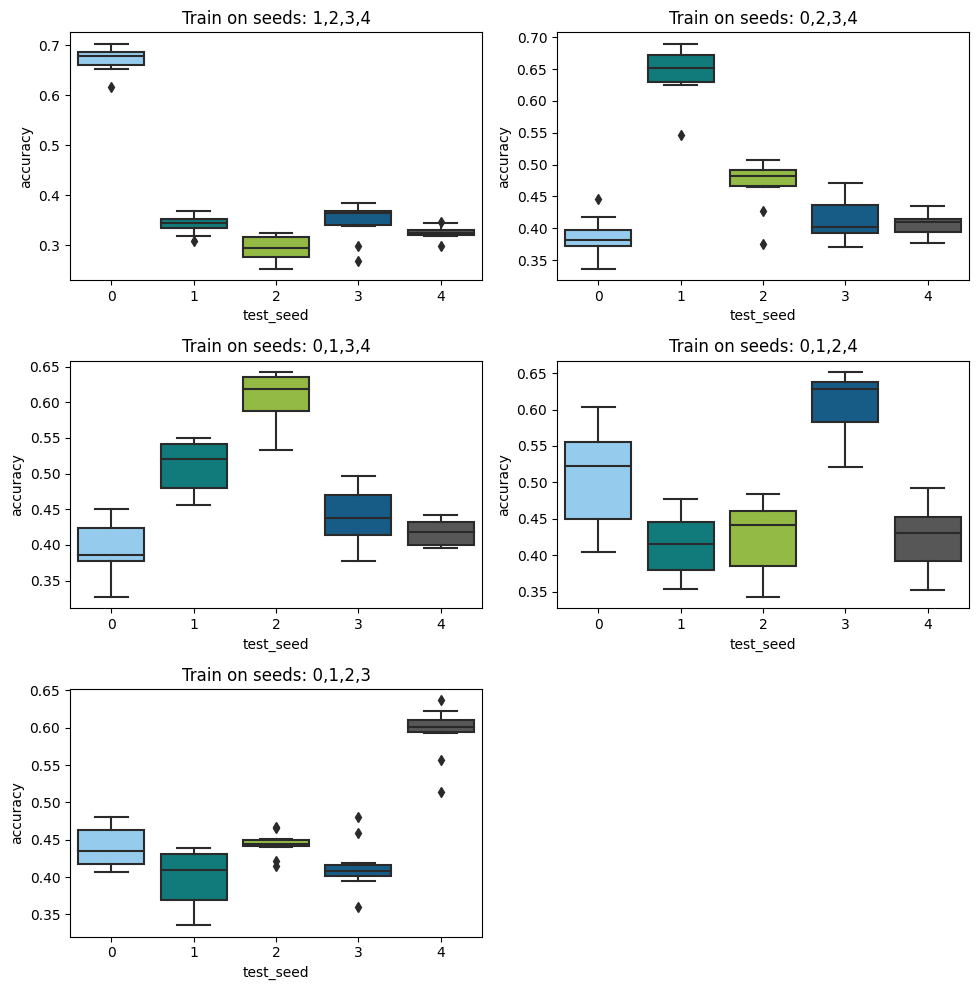

In [52]:
for algorithms_1 in ['DE']:
    for train_on_seed_1 in [True]:

            _,seed_accuracy_df = get_seed_accuracies_df(algorithms_1, train_on_seed_1, seeds)
            
            
            fig, axes = plt.subplots(3,2, figsize=(10,10))
            for seed_index, seed in enumerate(seeds):
                df_to_plot=seed_accuracy_df.query('train_seed==@seed')
                df_to_plot['test_seed']=df_to_plot['test_seed'].apply(lambda s: seed_mapping[s])
                ax=axes[int(seed_index/2)][seed_index%2]
                sns.boxplot(df_to_plot,y='accuracy', x='test_seed', palette=color_palette, ax= ax)
                training_seeds = str(seed_mapping[seed]) if train_on_seed else ','.join([seed_mapping[ss] for ss in list(filter(lambda s:s!=seed, seeds))])
                test_seeds = str(seed_mapping[seed]) if not train_on_seed else ','.join([seed_mapping[ss] for ss in list(filter(lambda s:s!=seed, seeds))])


                ax.set_title(f'Train on seeds: {training_seeds}')

            plt.tight_layout()
            fig.delaxes(axes[2][1])
            file_name=get_visualization_output_name_without_seed(algorithms, train_on_seed) + '_generalization_accuracy_boxplots.pdf'
            plt.savefig(file_name)

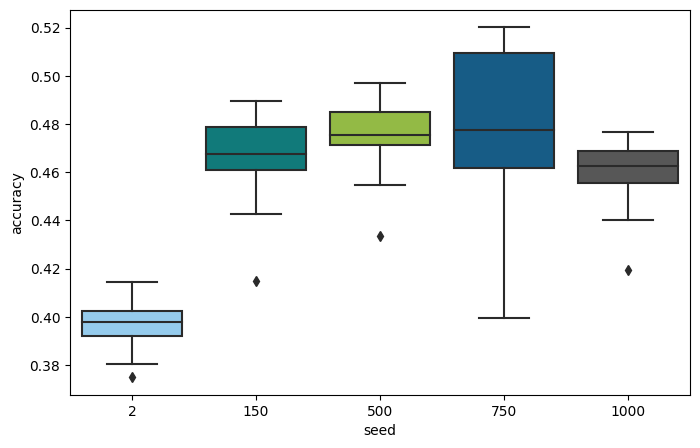

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(all_accuracies_df,y='accuracy', x='seed', palette=color_palette)
plt.savefig(os.path.join(visualizations_dir,f'{algorithms}_{iteration_start}-{iteration_end}_final_accuracy_boxplots.pdf'))

In [53]:
test_df_all,_=get_seed_accuracies_df(algorithms, train_on_seed, seeds)

In [54]:
test_df_all

,problem_id,instance_id,test_seed,y,preds,fold,train_seed
0,1,1,2,1,1,0,2
1,1,2,2,1,1,0,2
2,1,3,2,1,1,0,2
3,1,4,2,1,1,0,2
4,1,5,2,1,1,0,2
...,...,...,...,...,...,...,...
11875,24,995,1000,24,24,9,1000
11876,24,996,1000,24,24,9,1000
11877,24,997,1000,24,24,9,1000
11878,24,998,1000,24,24,9,1000


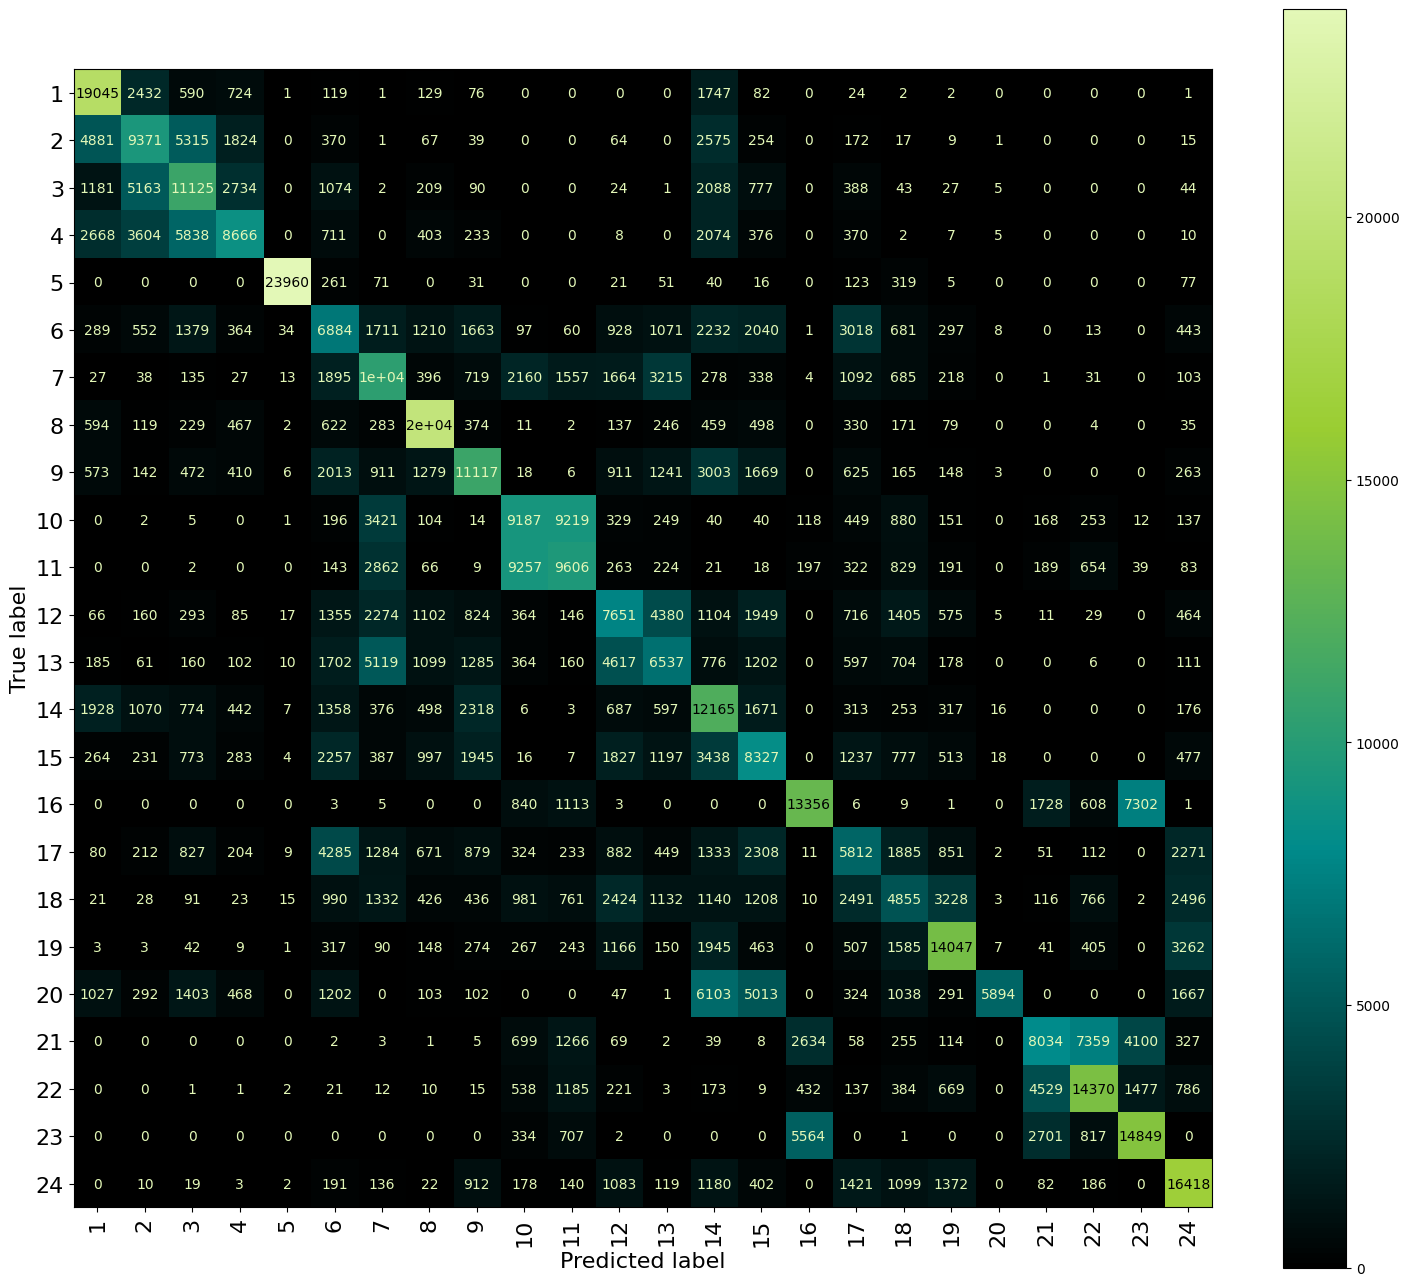

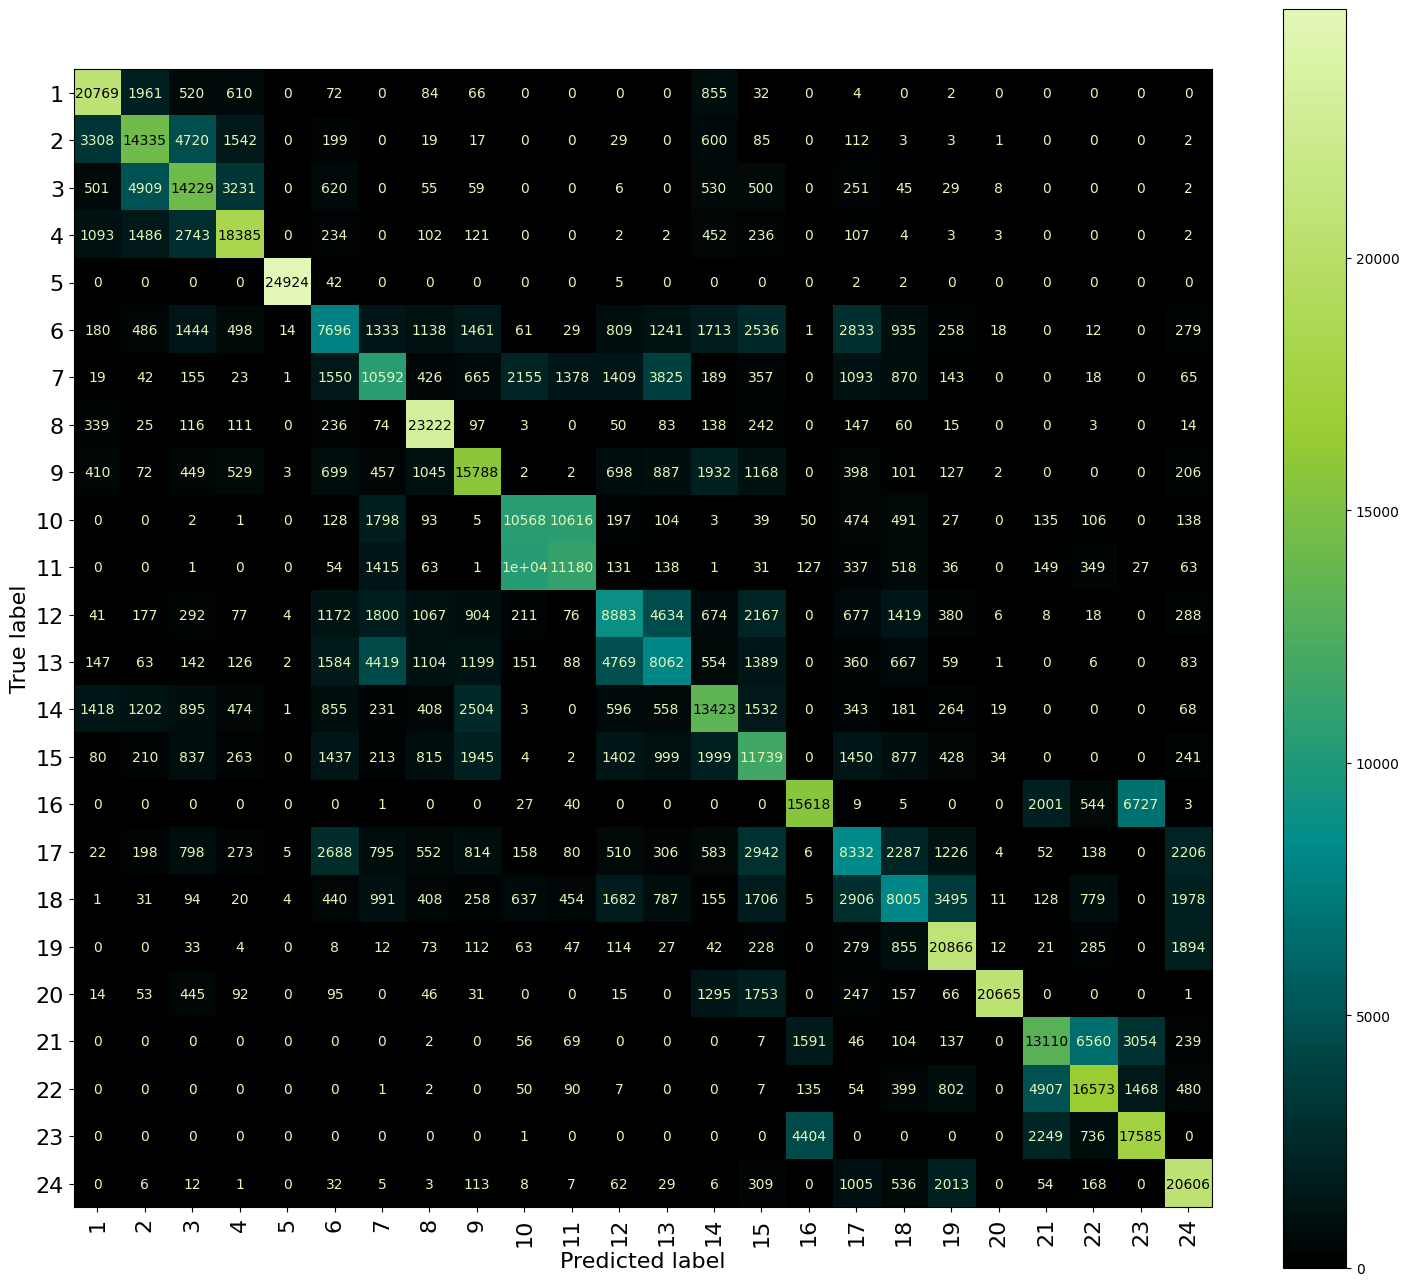

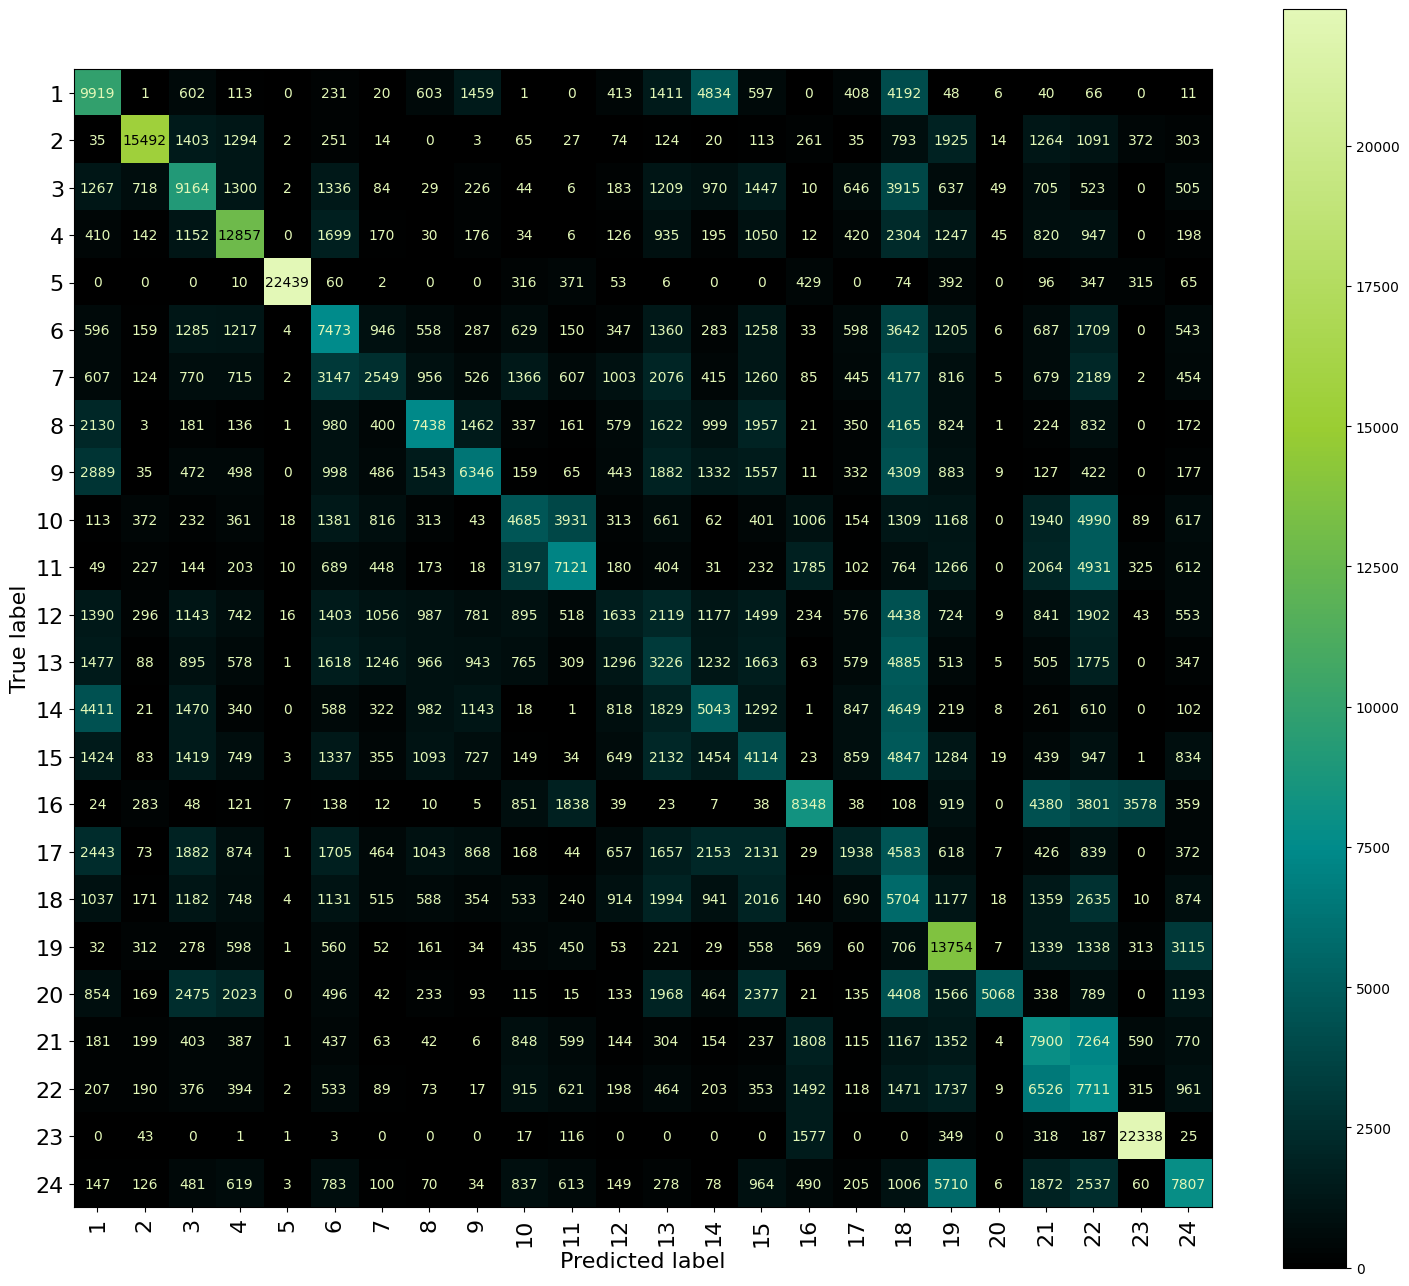

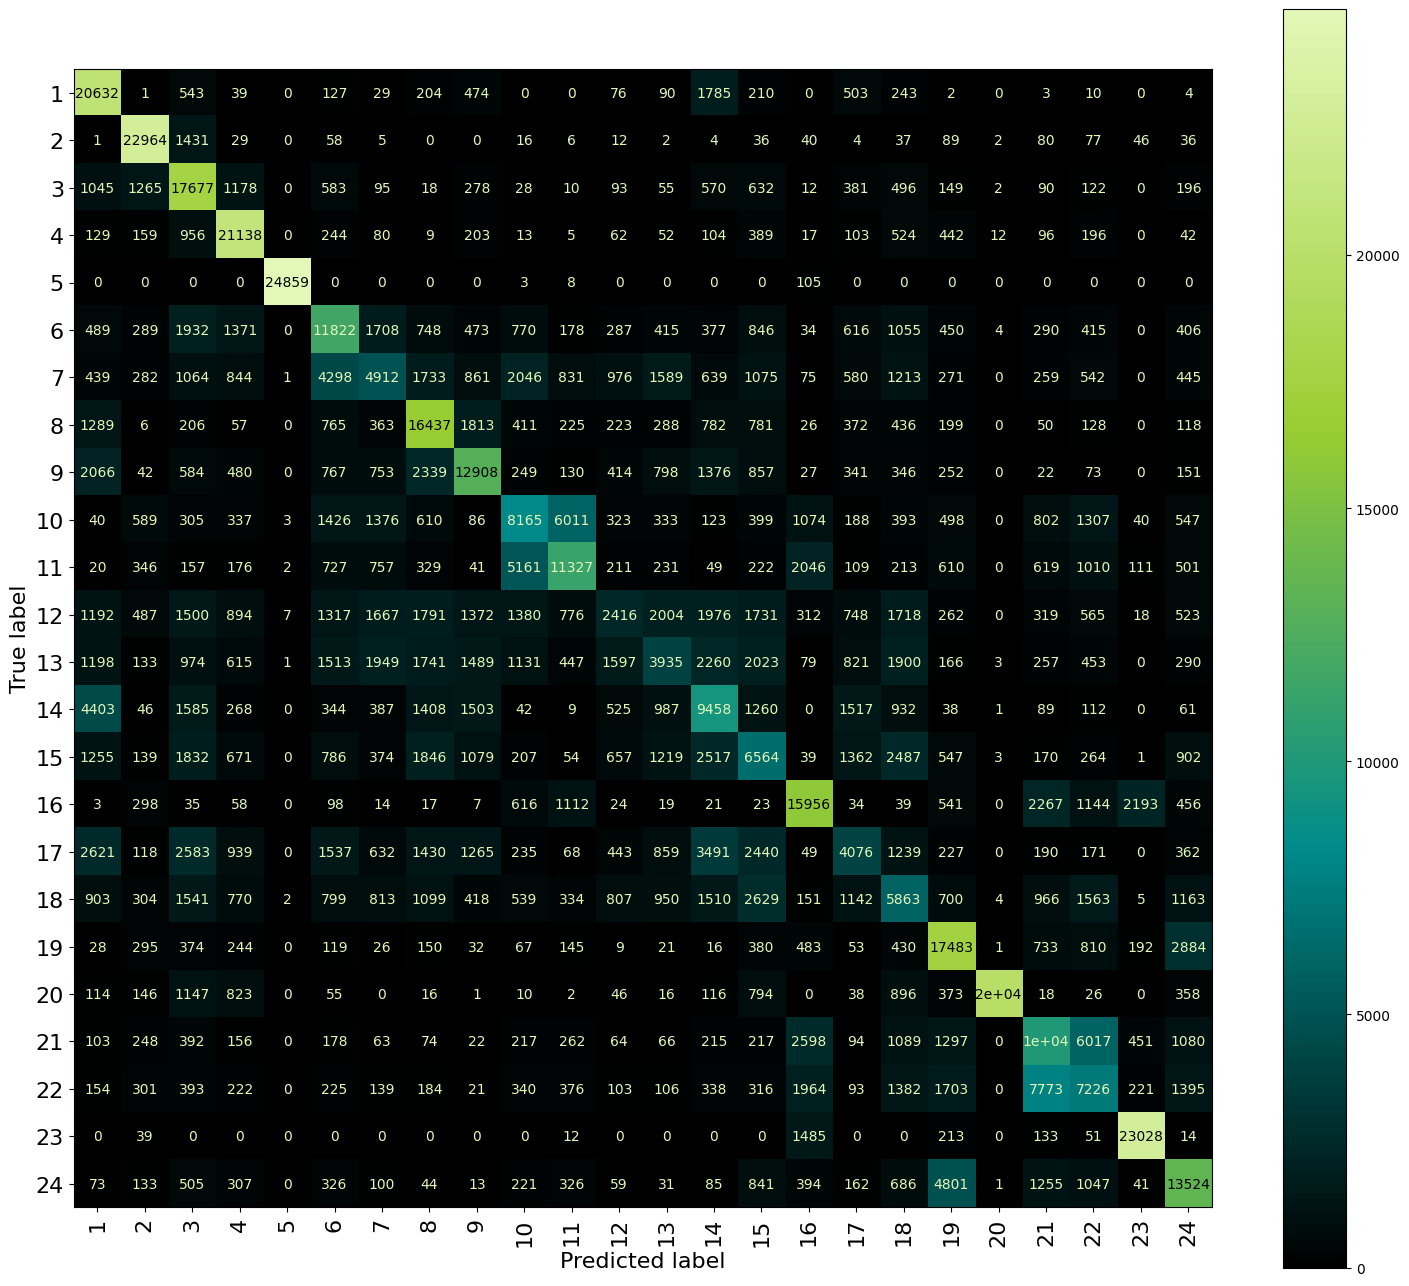

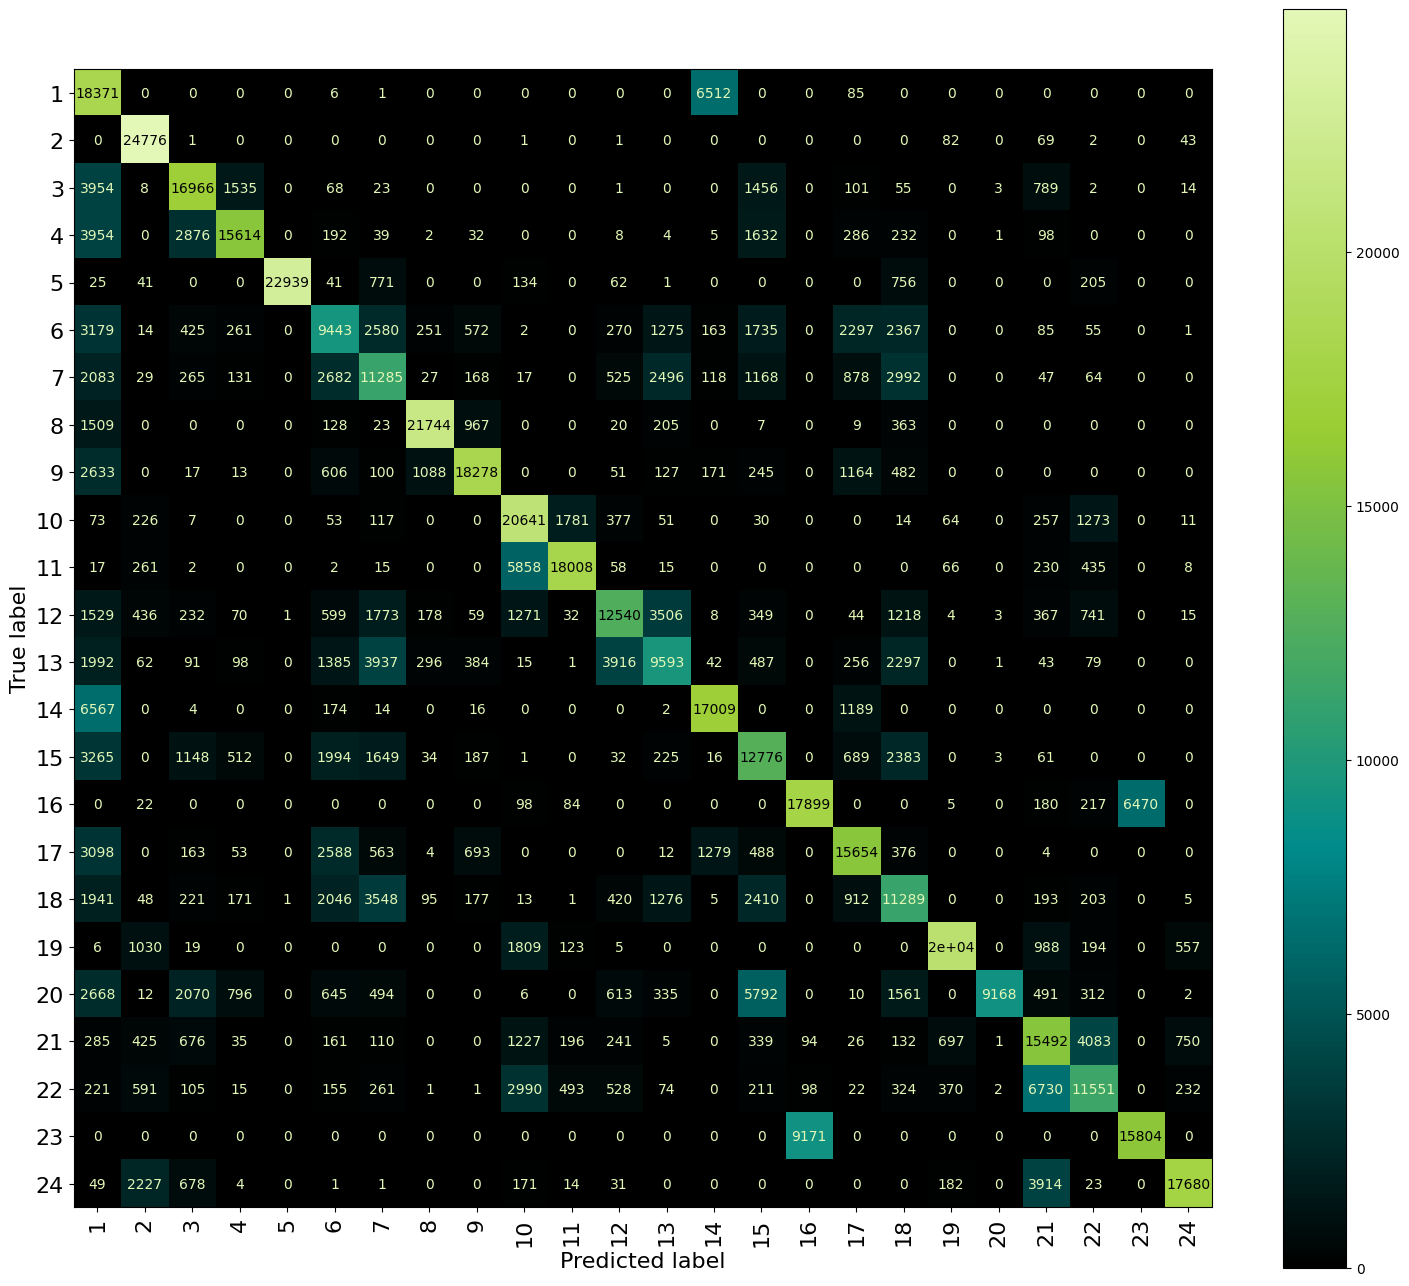

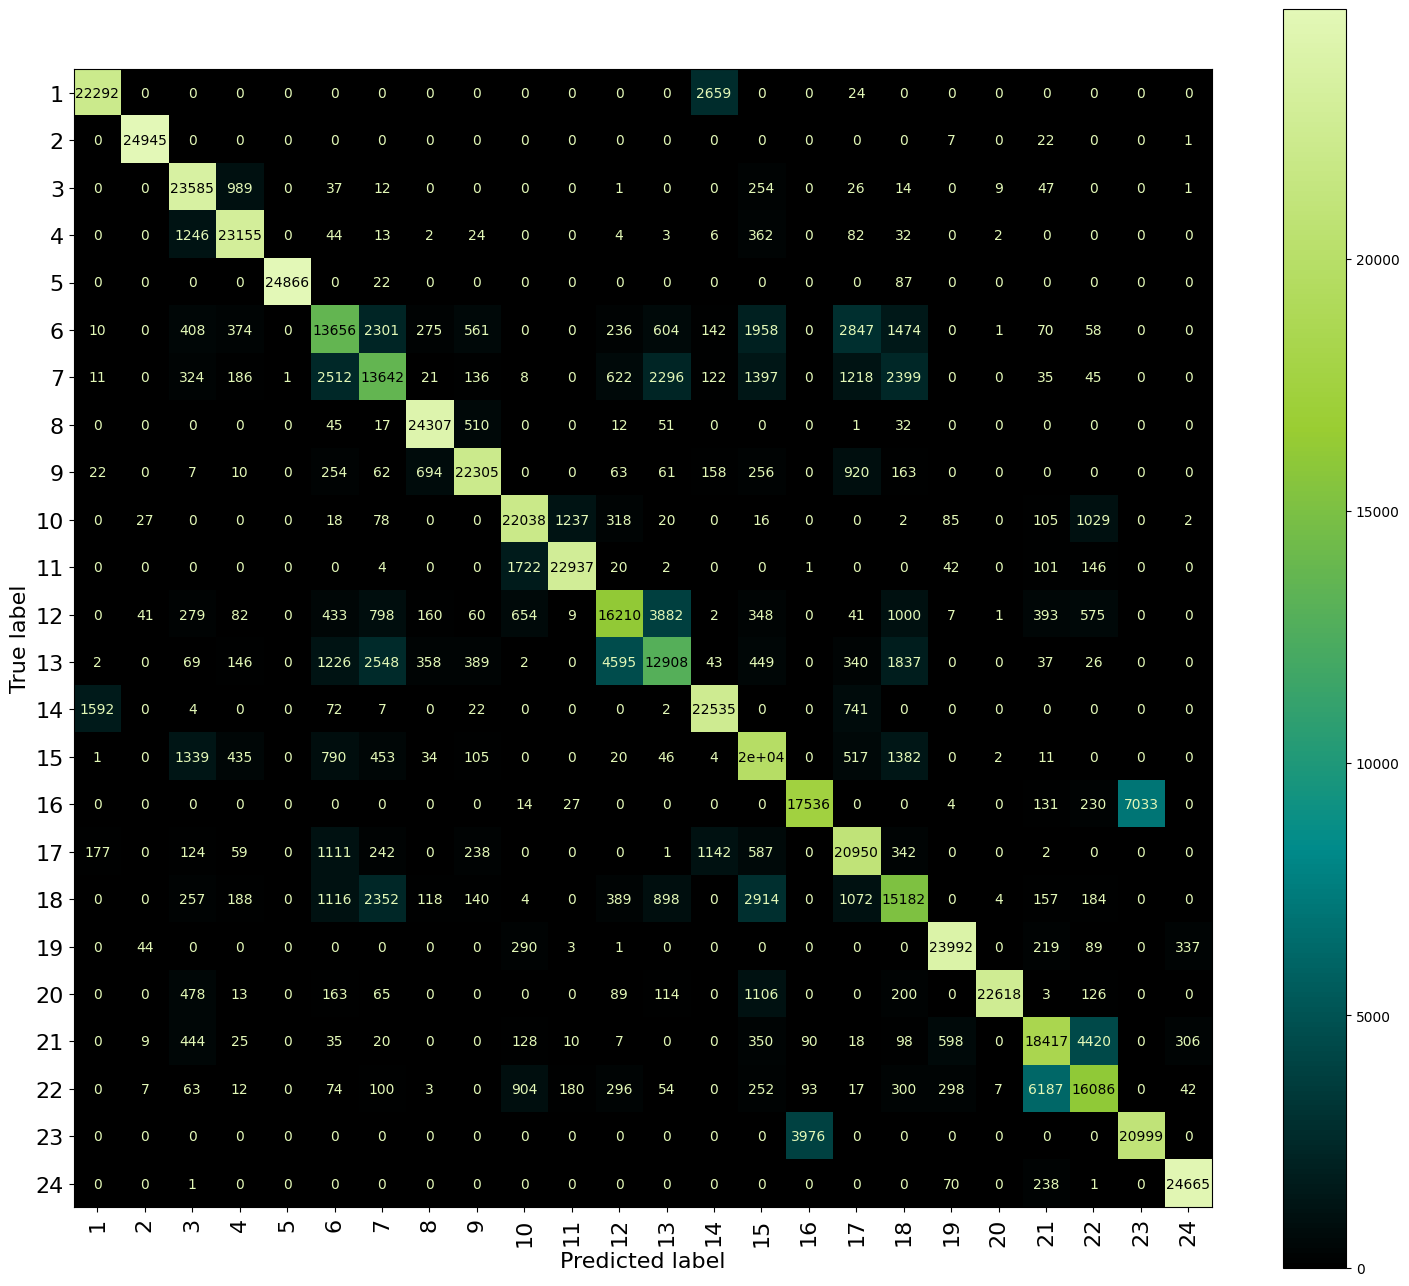

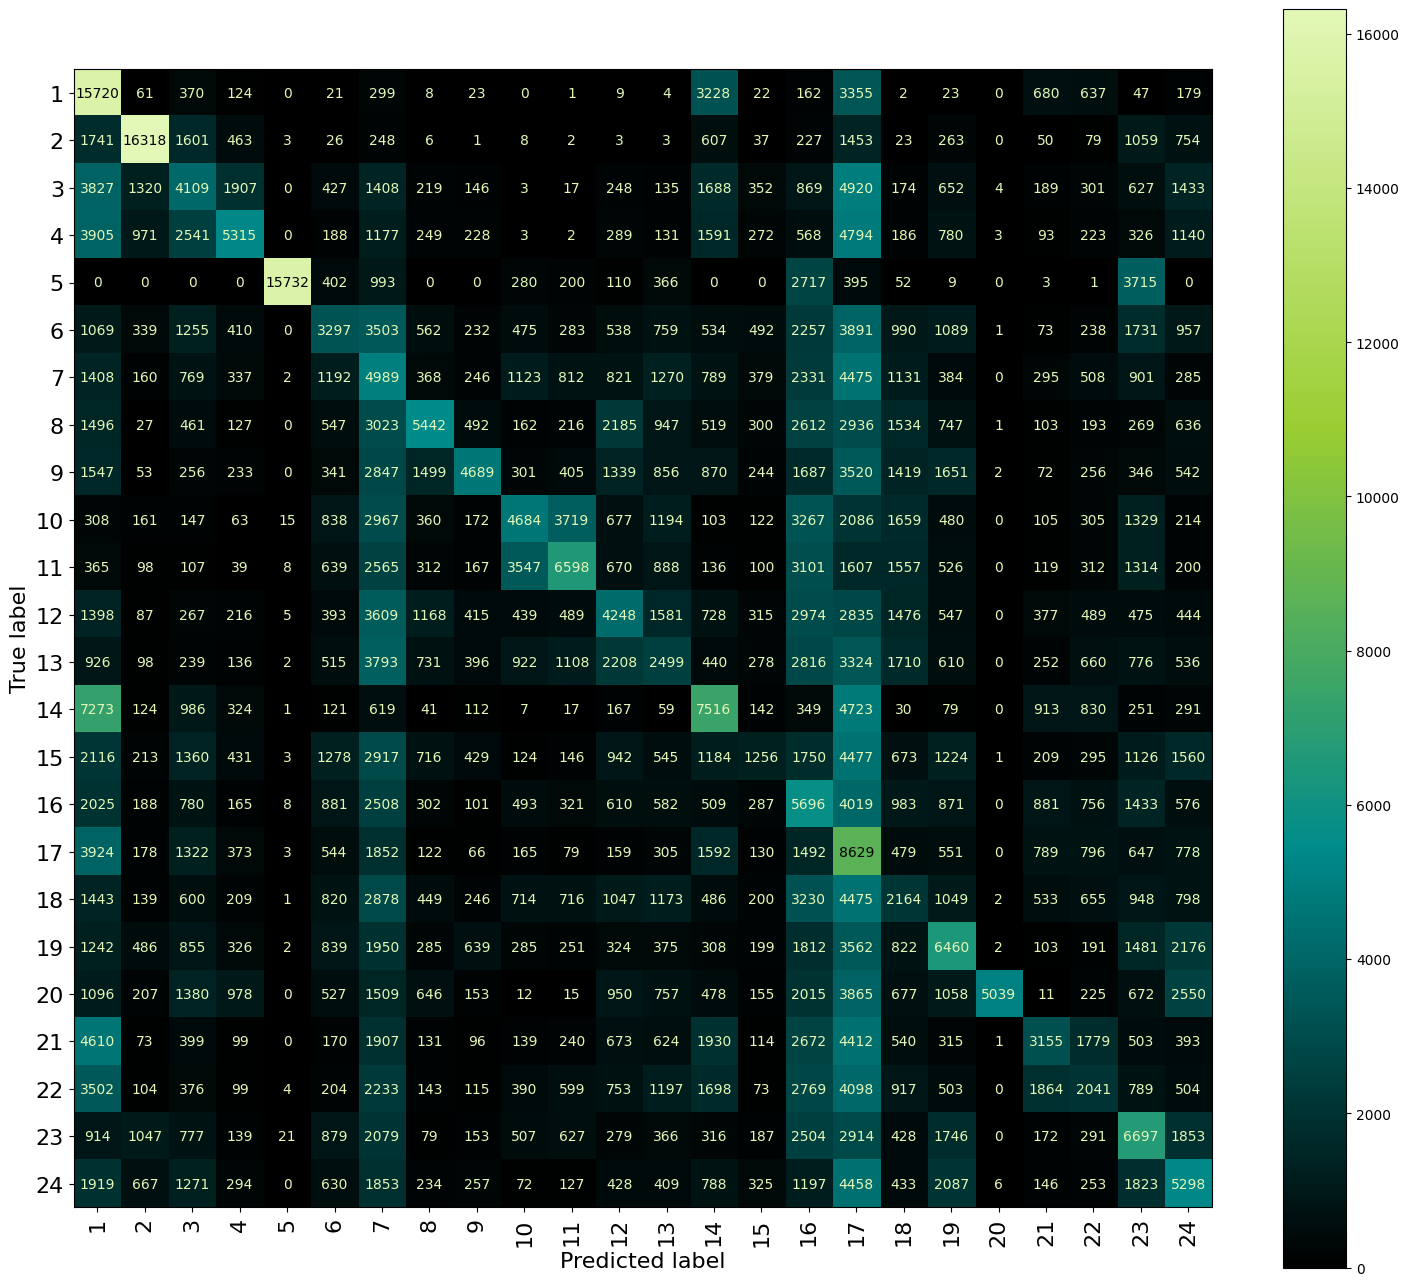

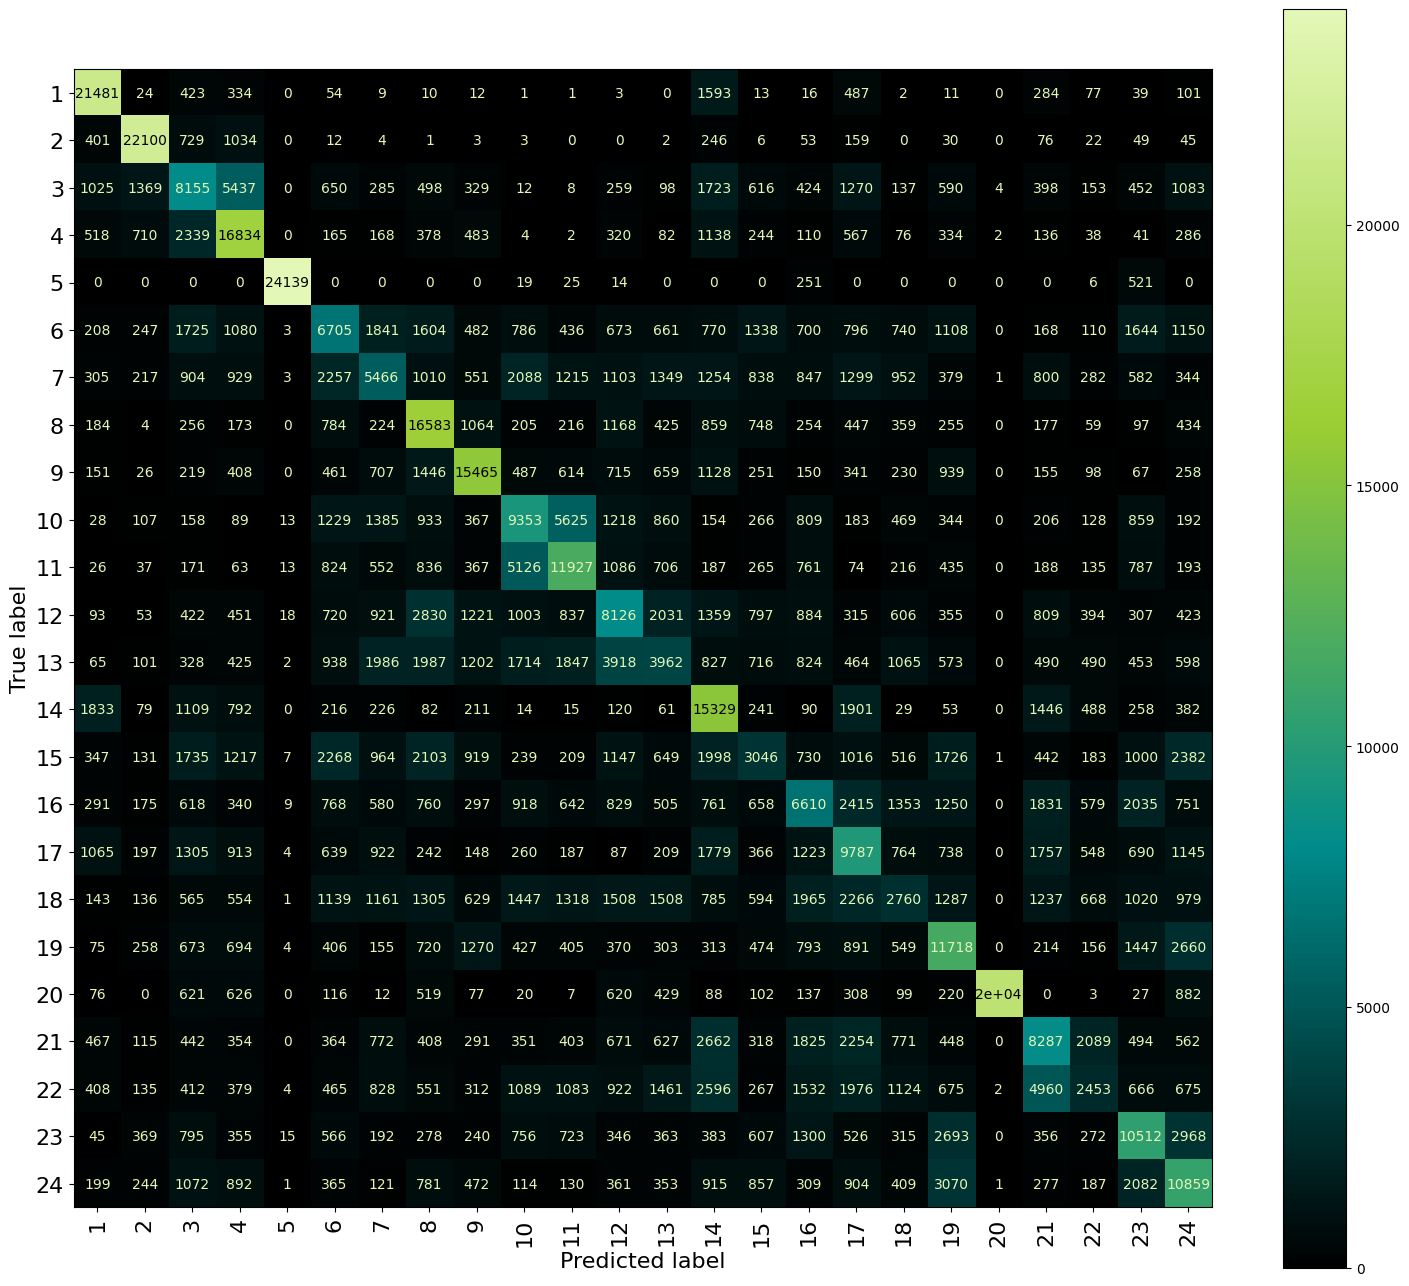

In [55]:
for algorithm_name_1 in ['DE','GA','ES','CMAES']:
    for train_on_seed_1 in [True,False]:
        test_df_all,seed_accuracy_df = get_seed_accuracies_df(algorithm_name_1, train_on_seed=train_on_seed_1, seeds=seeds)
        #test_df_all=test_df_all.query('train_seed==test_seed')
        fig, ax= plt.subplots(1,1,figsize=(15,13), sharey=True,squeeze=True)
        d=ConfusionMatrixDisplay.from_predictions(test_df_all['y'], test_df_all['preds'],cmap=my_cmap, colorbar=True, ax=ax)

        plt.xticks(rotation=90)

        #ax.set_xticklabels(ax.get_xticks(), rotation = 90)
        plt.tight_layout()
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(16)
        plt.savefig(os.path.join(visualizations_dir,f'ELA_{algorithm_name_1}_train_on_seed_{train_on_seed_1}_final_confusion_matrices_all_seeds.pdf'))

In [56]:
all_feature_importances_df=pd.DataFrame()
for algorithm in ['DE','GA','ES','CMAES']:
    
    for seed in seeds:
         for fold in range(0,10):

            global_file_name=get_global_file_name(algorithm,  train_on_seed,seed)
            file_location=global_file_name+f'_fold_{fold}_feature_importance.csv'

            if not os.path.isfile(file_location):
                print('Not found', file_location)
                continue
            #print(file_location)
            fold_importance_df=pd.read_csv(file_location, index_col=[0], compression='zip')
            fold_importance_df['seed']=seed
            fold_importance_df['fold']=fold
            fold_importance_df['algorithm']=algorithm
            all_feature_importances_df=pd.concat([all_feature_importances_df, fold_importance_df])
    

In [67]:
all_feature_importances_df_melted=pd.melt(all_feature_importances_df, id_vars=['fold','seed','algorithm'], value_vars=all_feature_importances_df.columns)

In [68]:
features_by_importance=all_feature_importances_df_melted.groupby('variable').median().sort_values('value', ascending=False).index

/tmp/ipykernel_3234/2161365857.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  features_by_importance=all_feature_importances_df_melted.groupby('variable').median().sort_values('value', ascending=False).index


In [69]:
all_feature_importances_df.dropna().shape

(200, 49)

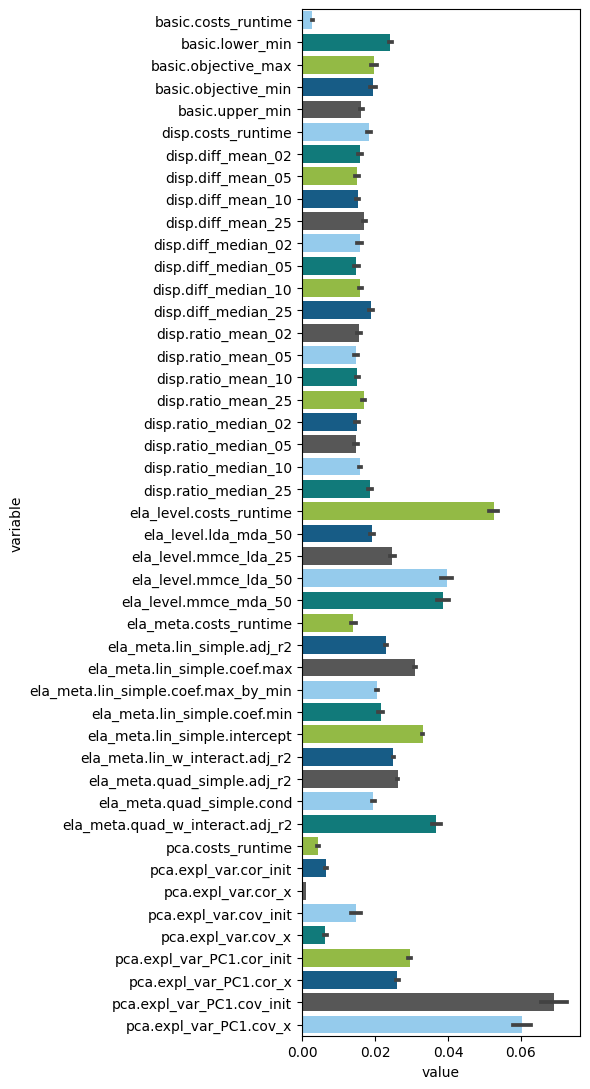

In [70]:
plt.figure(figsize=(6,11))

sns.barplot(all_feature_importances_df_melted.sort_values('variable'), y='variable',x='value',palette=color_palette)
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir,'ela_feature_importance.pdf'))

In [ ]:
all_feature_importances_df.drop(columns=['seed','fold']).mean().sort_values()

In [ ]:
top_feature_importances=[]
feature_importance_scores=pd.DataFrame()
for seed in seeds:
    seed_feature_importances_df=all_feature_importances_df.query('seed==@seed')
    sorted_feature_importance=seed_feature_importances_df.drop(columns=['seed']).median().sort_values(ascending=False).to_frame()
    top_features = list(sorted_feature_importance.index)[:20]+['seed']
    
    sorted_feature_importance['rank']=list(range(0,sorted_feature_importance.shape[0]))
    
    sorted_feature_importance['seed']=seed
    feature_importance_scores=pd.concat([feature_importance_scores,sorted_feature_importance.reset_index()])
    top_feature_importances+=top_features
    all_feature_importances=[]
    for index, row in seed_feature_importances_df[top_features ].iterrows():
        for index2 in row.keys():
            if index2 not in ['seed','fold']:
                all_feature_importances+=[(index,index2,row[index2],row['seed'])]
    feature_importance_df=pd.DataFrame(all_feature_importances, columns=['fold','feature_name','importance','seed'])
    plt.figure()
    sns.boxplot(feature_importance_df,y='importance', x='feature_name',  palette=color_palette)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir,f'{algorithms}_{iteration_start}-{iteration_end}_final_top_20_features_boxplots_seeds_{seed}.pdf'))
print(pd.DataFrame(top_feature_importances).value_counts())
print(feature_importance_scores)
    

In [ ]:
feature_importance_scores

In [ ]:
top_ranked=feature_importance_scores.groupby('index').median()['rank'].sort_values(ascending=True)[:20].index
top_ranked_df=feature_importance_scores.set_index('index').loc[top_ranked]
print(top_ranked_df)
sns.boxplot(top_ranked_df.reset_index(),y='rank', x='index',  palette=color_palette)

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir,f'{algorithms}_{iteration_start}-{iteration_end}_final_top_20_features_boxplots_ranks.pdf'))